We construct a Generative Adversarial Network training with 0.1% of the total data. We do this for 3500 iterations, and every 50 iterations we compare our generated fake data to the real training data. We then save the iteration with the best score to be used later to compare with a larger set of the total dataset. The comaprisons are done via ROC auc score.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sbs

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten ,Input# core layers
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import SGD,Adam
from keras import backend as K

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,log_loss

np.random.seed(2210)

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
font_size = 24

Using Theano backend.


In [2]:
# Scale data function
def preprocess_data(X):
        a = X.min(axis=0)
        b = X.max(axis=0)
        c = b-(b+a)/2.
        def scale(X):
            return((X-(b+a)/2.)/c*(1.-1e-6))
        def inverse_scale(X):
            return(X*c/(1.-1e-6)+(b+a)/2.)
        X = scale(X)
        return X, scale,inverse_scale

#Sample 
def data_sample(data,n):
    return data[np.random.randint(data.shape[0],size=n)]

In [3]:
nfolds = 10
folds = StratifiedKFold(n_splits=nfolds,random_state=1,shuffle=True)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 15,
    'max_depth': 4,
    'learning_rate': .3,
    'num_threads': 4,
    'is_unbalance':'true'
}

def get_roc_score():
    #Generate current fake samples
    u_dist = np.random.normal(size=(100000, sample_dim)).astype('float32')
    gn_dist = sample_fake((u_dist,))
    #Create data to compute roc auc score
    data2 = np.vstack([gn_dist,X_train])
    y_d = np.array([0]*gn_dist.shape[0]+[1]*X_train.shape[0])
    
    #Predict over folds
    predict = np.empty(len(y_d))
    models = []
    for train_index,test_index in folds.split(data2,y_d):
        X_tr = data2[train_index]
        X_ts = data2[test_index]
        y_tr = y_d[train_index]
        y_ts = y_d[test_index]
        dtrain = lgb.Dataset(X_tr,y_tr)
        dtest = lgb.Dataset(X_ts, y_ts,reference=dtrain)
        gbm = lgb.train(params, dtrain, 
                    num_boost_round=2000,
                    valid_sets=dtest,
                    early_stopping_rounds=10,
                    verbose_eval=0)
        models.append(gbm)
        predict[test_index] = gbm.predict(X_ts,num_iteration=gbm.best_iteration)
    return roc_auc_score(y_d,predict)

Load data and select randomly 10000 events to train the generative system.

In [4]:
folder = '../../Data/Federico/'
data = pd.read_csv(folder+"RPA.txt.gz",header=None).values

In [5]:
trainIndices = np.random.choice(np.arange(data.shape[0]),size=10000,replace=False)
X_train2 = data[trainIndices]

In [6]:
X_train, scale, inverse_scale = preprocess_data(X_train2)

In [7]:
sdata = scale(data)

In [8]:
# use GAN to generate gaussian distribution from uniform distribution
batch_size = 512
data_dim = X_train.shape[1]
mid_dim_1 = 6*data_dim #Discriminator hidden layer size
sample_dim = data_dim*(data_dim+1)
mid_dim_2 = sample_dim #Generator hidden layer size

Generative network

In [9]:
# simple mlp discriminator
discriminator = Sequential()
discriminator.add(Dense(mid_dim_1, input_dim=data_dim))
discriminator.add(LeakyReLU())
discriminator.add(Dense(mid_dim_1))
discriminator.add(LeakyReLU())
discriminator.add(Dense(mid_dim_1))
discriminator.add(LeakyReLU())
discriminator.add(Dense(1, activation='sigmoid'))

# simple mlp generator
generator = Sequential()
generator.add(Dense(mid_dim_2, input_dim=sample_dim))
generator.add(LeakyReLU())
generator.add(Dense(mid_dim_2))
generator.add(LeakyReLU())
generator.add(Dense(mid_dim_2))
generator.add(LeakyReLU())
generator.add(Dense(mid_dim_2))
generator.add(LeakyReLU())
generator.add(Dense(data_dim, activation='tanh'))
sample_fake = K.function([generator.input], generator.output)


discriminator.trainable = False
generator.add(discriminator)

# training setting
opt_g = Adam(lr=.001) 
generator.compile(loss='binary_crossentropy', optimizer=opt_g)
opt_d = Adam(lr=.002)
discriminator.trainable = True
discriminator.compile(loss='binary_crossentropy', optimizer=opt_d)

In [10]:
# pre-train the discriminator, not necessary in this simple example
n_dist = data_sample(X_train,batch_size * 100).astype('float32')
u_dist = np.random.normal(size=(batch_size * 100, sample_dim)).astype('float32')
gn_dist = sample_fake((u_dist,))
true_n_fake = np.vstack([n_dist, gn_dist])

y_batch = np.hstack([np.ones((batch_size * 100, )),
                     np.zeros((batch_size * 100, ))])
discriminator.fit(true_n_fake, y_batch, batch_size=batch_size, epochs=20, verbose=0)

In [11]:
%%time
ll = []
bestRoc = get_roc_score()
for i in range(35001):
    if i % 50 == 0:
        rocScore = get_roc_score()
        print("Iteration:",i,"ROC:",rocScore)
        ll.append([i,rocScore])
        if rocScore < bestRoc:
            bestRoc = rocScore
            generator.save("best_generator")
            discriminator.save("best_discriminator")
        
    for k in range(15):
        n_dist = data_sample(X_train,batch_size).astype('float32')
        discriminator.train_on_batch(n_dist, np.random.uniform(0.7,1.2,batch_size))
        u_dist = np.random.normal(size=(batch_size, sample_dim)).astype('float32')
        gn_dist = sample_fake((u_dist,))    
        discriminator.train_on_batch(gn_dist, np.random.uniform(0.,0.3,batch_size))
                          
        
    all_fake = np.ones((batch_size, )).astype('float32')
    u_dist = np.random.normal(size=(batch_size, sample_dim)).astype('float32')
    generator.train_on_batch(u_dist, all_fake)

Iteration: 0 ROC: 0.99990431
Iteration: 50 ROC: 0.9664802215
Iteration: 100 ROC: 0.848140737
Iteration: 150 ROC: 0.823573303
Iteration: 200 ROC: 0.825672236
Iteration: 250 ROC: 0.788174684
Iteration: 300 ROC: 0.7444821675
Iteration: 350 ROC: 0.714568207
Iteration: 400 ROC: 0.694711571
Iteration: 450 ROC: 0.6904093425
Iteration: 500 ROC: 0.675244572
Iteration: 550 ROC: 0.7945793535
Iteration: 600 ROC: 0.801560944
Iteration: 650 ROC: 0.6793978385
Iteration: 700 ROC: 0.7471063995
Iteration: 750 ROC: 0.7126314015
Iteration: 800 ROC: 0.662578733
Iteration: 850 ROC: 0.748231906
Iteration: 900 ROC: 0.7551266675
Iteration: 950 ROC: 0.7866581255
Iteration: 1000 ROC: 0.7006272105
Iteration: 1050 ROC: 0.7827485645
Iteration: 1100 ROC: 0.7181622185
Iteration: 1150 ROC: 0.697762847
Iteration: 1200 ROC: 0.7019672325
Iteration: 1250 ROC: 0.6782781625
Iteration: 1300 ROC: 0.668715245
Iteration: 1350 ROC: 0.732806391
Iteration: 1400 ROC: 0.8643848185
Iteration: 1450 ROC: 0.6725163215
Iteration: 1500 RO

Iteration: 12250 ROC: 0.5589909525
Iteration: 12300 ROC: 0.548372444
Iteration: 12350 ROC: 0.6099134225
Iteration: 12400 ROC: 0.611285423
Iteration: 12450 ROC: 0.5958475235
Iteration: 12500 ROC: 0.596349356
Iteration: 12550 ROC: 0.583442982
Iteration: 12600 ROC: 0.5617677225
Iteration: 12650 ROC: 0.547718239
Iteration: 12700 ROC: 0.549967569
Iteration: 12750 ROC: 0.5477515035
Iteration: 12800 ROC: 0.5456110005
Iteration: 12850 ROC: 0.5461085555
Iteration: 12900 ROC: 0.544449128
Iteration: 12950 ROC: 0.5382536715
Iteration: 13000 ROC: 0.544532929
Iteration: 13050 ROC: 0.5360892485
Iteration: 13100 ROC: 0.5382602505
Iteration: 13150 ROC: 0.541681759
Iteration: 13200 ROC: 0.545056512
Iteration: 13250 ROC: 0.5453104685
Iteration: 13300 ROC: 0.5422799125
Iteration: 13350 ROC: 0.541371631
Iteration: 13400 ROC: 0.5484624295
Iteration: 13450 ROC: 0.545429085
Iteration: 13500 ROC: 0.5450789355
Iteration: 13550 ROC: 0.535566735
Iteration: 13600 ROC: 0.5361881195
Iteration: 13650 ROC: 0.542485756

Iteration: 24150 ROC: 0.550236161
Iteration: 24200 ROC: 0.5522689395
Iteration: 24250 ROC: 0.5470978775
Iteration: 24300 ROC: 0.5519666735
Iteration: 24350 ROC: 0.544728494
Iteration: 24400 ROC: 0.5485947895
Iteration: 24450 ROC: 0.545177964
Iteration: 24500 ROC: 0.5534284725
Iteration: 24550 ROC: 0.5469879845
Iteration: 24600 ROC: 0.544068792
Iteration: 24650 ROC: 0.535575994
Iteration: 24700 ROC: 0.5413215855
Iteration: 24750 ROC: 0.5496750855
Iteration: 24800 ROC: 0.5534665935
Iteration: 24850 ROC: 0.554577158
Iteration: 24900 ROC: 0.5636212245
Iteration: 24950 ROC: 0.552200496
Iteration: 25000 ROC: 0.546418105
Iteration: 25050 ROC: 0.552468621
Iteration: 25100 ROC: 0.5509283175
Iteration: 25150 ROC: 0.553639482
Iteration: 25200 ROC: 0.55424949
Iteration: 25250 ROC: 0.5704468555
Iteration: 25300 ROC: 0.5639076505
Iteration: 25350 ROC: 0.603349277
Iteration: 25400 ROC: 0.590968842
Iteration: 25450 ROC: 0.747335092
Iteration: 25500 ROC: 0.6860154795
Iteration: 25550 ROC: 0.794178923
I

In [12]:
llnp = np.array(ll)
np.save('llnp.npy',llnp)

Iteration: 16150.0 Roc score: 0.528416478


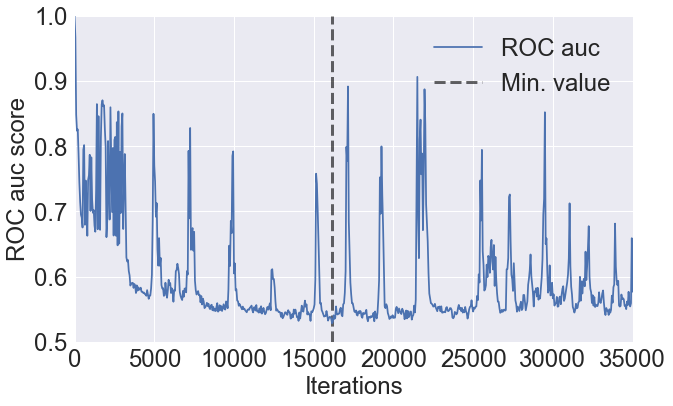

In [41]:
llnp = np.load('llnp.npy')
bestIt = llnp[:,0][np.argmin(llnp[:,1])]
bestRoc = llnp[:,1].min()
plt.plot(llnp[:,0],llnp[:,1],label='ROC auc')
plt.xlabel("Iterations",fontsize=font_size)
plt.ylabel("ROC auc score",fontsize=font_size)
plt.vlines(bestIt,0.5,1,lw=3,linestyle='dashed',alpha=0.6,
          label='Min. value')
plt.tick_params(labelsize=font_size)
plt.legend(fontsize=font_size)
plt.xlim(0,35000)
plt.ylim(0.5,1)
plt.savefig('GANIter.pdf')
print("Iteration:",bestIt,"Roc score:",bestRoc)

In [ ]:
generator.save("final_generator")
discriminator.save("final_discriminator")

In [10]:
generator.load_weights('best_generator')
discriminator.load_weights('best_discriminator')

Create new sample from the generator and plot the obtained distribution, comparing the generated sample to both the sample used for training from  the original data and the total data.

In [11]:
np.random.seed(2210)
u_dist = np.random.normal(size=(100000, sample_dim)).astype('float32')
gn_dist = sample_fake((u_dist,))

In [12]:
from scipy.stats import gaussian_kde

def kde_plot(data,xmin = -5, xmax = 5,label=None):
    density = gaussian_kde(data)
    xs = np.linspace(xmin,xmax,200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs),alpha=0.6,lw=5,label=label)

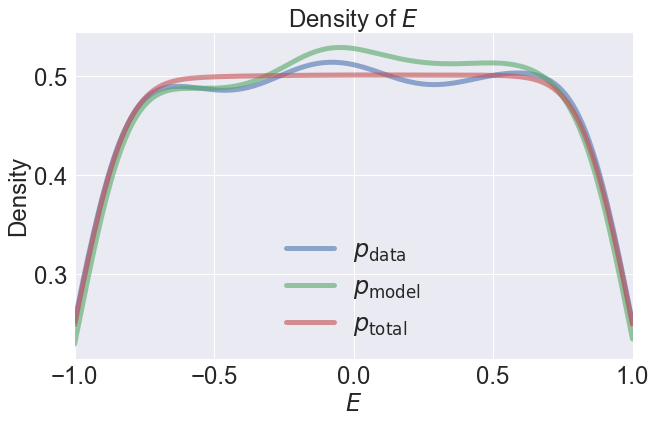

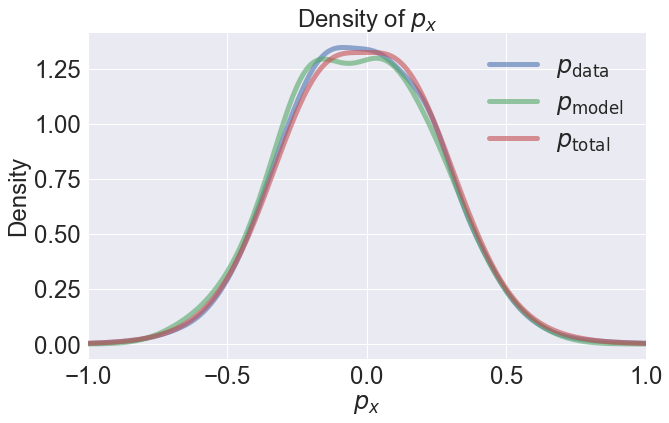

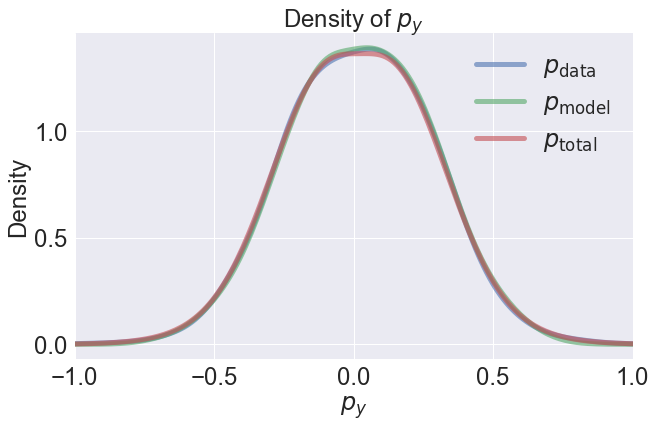

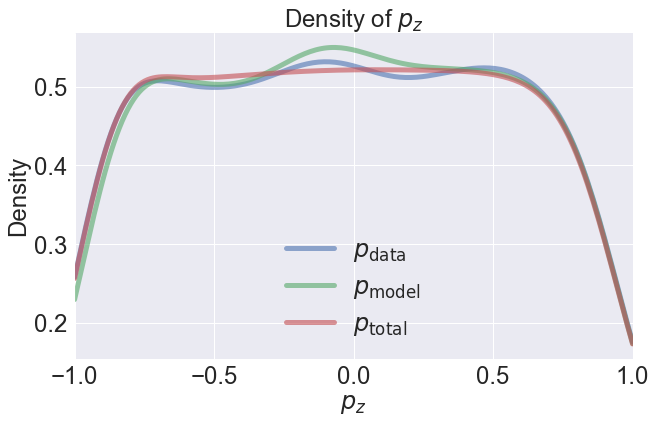

In [15]:
xlabels = ['$E$','$p_x$','$p_y$','$p_z$']
for i in range(data_dim):
    plt.figure()
    plt.xlim(-1,1)
    kde_plot(X_train[:,i],-1,1,label='$p_{\mathrm{data}}$')
    kde_plot(gn_dist[:,i],-1,1,label='$p_{\mathrm{model}}$')
    kde_plot(sdata[:,i],-1,1,label='$p_{\mathrm{total}}$')
    plt.title('Density of %s' % xlabels[i],fontsize= font_size)
    plt.ylabel("Density",fontsize=font_size)
    plt.xlabel(xlabels[i],fontsize=font_size)
    plt.tick_params(labelsize=font_size)
    plt.legend(fontsize=font_size)
    plt.savefig('GANdens%d.pdf'%(i+1))

Try to distinguish generated data from real data.

In [18]:
nfolds = 10
folds = StratifiedKFold(n_splits=nfolds,random_state=1,shuffle=True)

In [19]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 15,
    'max_depth': 4,
    'learning_rate': .3,
    'num_threads': 4,
    'is_unbalance':'true'
}

In [20]:
np.random.seed(2210)
data2 = np.vstack([gn_dist,X_train])
y_d = np.array([0]*gn_dist.shape[0]+[1]*X_train.shape[0])

predict = np.empty(len(y_d))
models = []
for train_index,test_index in folds.split(data2,y_d):
    X_tr = data2[train_index]
    X_ts = data2[test_index]
    y_tr = y_d[train_index]
    y_ts = y_d[test_index]
    dtrain = lgb.Dataset(X_tr,y_tr)
    dtest = lgb.Dataset(X_ts, y_ts,reference=dtrain)
    gbm = lgb.train(params, dtrain, 
                num_boost_round=2000,
                valid_sets=dtest,
                early_stopping_rounds=10,
                verbose_eval=0)
    models.append(gbm)
    predict[test_index] = gbm.predict(X_ts,num_iteration=gbm.best_iteration)

In [21]:
print("Roc score:", roc_auc_score(y_d,predict))

Roc score: 0.5348959425


We now compare it to the total sampling.

In [12]:
np.random.seed(2210+1)
newIndices = np.random.choice(np.arange(sdata.shape[0]),size=510000,replace=False)

In [21]:
newIndices = np.hstack(set(newIndices).difference(set(trainIndices)))[:500000]

In [22]:
sdataTrain = sdata[newIndices]

In [23]:
u_dist = np.random.normal(size=(500000, sample_dim)).astype('float32')
gn_dist = sample_fake((u_dist,))

In [24]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 15,
    'max_depth': 4,
    'learning_rate': .3,
    'num_threads': 4,
}

In [25]:
data2 = np.vstack([gn_dist,sdataTrain])
y_d = np.array([0]*gn_dist.shape[0]+[1]*sdataTrain.shape[0])

predict = np.empty(len(y_d))
models = []
for train_index,test_index in folds.split(data2,y_d):
    X_tr = data2[train_index]
    X_ts = data2[test_index]
    y_tr = y_d[train_index]
    y_ts = y_d[test_index]
    dtrain = lgb.Dataset(X_tr,y_tr)
    dtest = lgb.Dataset(X_ts, y_ts,reference=dtrain)
    gbm = lgb.train(params, dtrain, 
                num_boost_round=4000,
                valid_sets=dtest,
                early_stopping_rounds=10,
                verbose_eval=50)
    models.append(gbm)
    predict[test_index] = gbm.predict(X_ts,num_iteration=gbm.best_iteration)
print("Roc score:", roc_auc_score(y_d,predict))

Train until valid scores didn't improve in 10 rounds.
[50]	valid_0's auc: 0.566948
[100]	valid_0's auc: 0.57679
[150]	valid_0's auc: 0.582259
[200]	valid_0's auc: 0.586514
[250]	valid_0's auc: 0.590068
[300]	valid_0's auc: 0.592842
[350]	valid_0's auc: 0.595498
[400]	valid_0's auc: 0.596994
[450]	valid_0's auc: 0.59882
[500]	valid_0's auc: 0.599845
Early stopping, best iteration is:
[539]	valid_0's auc: 0.600623
Train until valid scores didn't improve in 10 rounds.
[50]	valid_0's auc: 0.566663
[100]	valid_0's auc: 0.57599
[150]	valid_0's auc: 0.582234
[200]	valid_0's auc: 0.586682
[250]	valid_0's auc: 0.589742
[300]	valid_0's auc: 0.592502
[350]	valid_0's auc: 0.594823
Early stopping, best iteration is:
[376]	valid_0's auc: 0.596044
Train until valid scores didn't improve in 10 rounds.
[50]	valid_0's auc: 0.567026
[100]	valid_0's auc: 0.57603
[150]	valid_0's auc: 0.582696
[200]	valid_0's auc: 0.586317
[250]	valid_0's auc: 0.590057
[300]	valid_0's auc: 0.592981
[350]	valid_0's auc: 0.59

The score is not so good, but let us see how good the discriminator does with the subsample we used to train the GAN

In [26]:
data2 = np.vstack([X_train,sdataTrain])
y_d = np.array([0]*X_train.shape[0]+[1]*sdataTrain.shape[0])

predict = np.empty(len(y_d))
models = []
for train_index,test_index in folds.split(data2,y_d):
    X_tr = data2[train_index]
    X_ts = data2[test_index]
    y_tr = y_d[train_index]
    y_ts = y_d[test_index]
    dtrain = lgb.Dataset(X_tr,y_tr)
    dtest = lgb.Dataset(X_ts, y_ts,reference=dtrain)
    gbm = lgb.train(params, dtrain, 
                num_boost_round=4000,
                valid_sets=dtest,
                early_stopping_rounds=10,
                verbose_eval=50)
    models.append(gbm)
    predict[test_index] = gbm.predict(X_ts,num_iteration=gbm.best_iteration)
print("Roc score:", roc_auc_score(y_d,predict))

Train until valid scores didn't improve in 10 rounds.
Early stopping, best iteration is:
[22]	valid_0's auc: 0.512494
Train until valid scores didn't improve in 10 rounds.
Early stopping, best iteration is:
[14]	valid_0's auc: 0.518856
Train until valid scores didn't improve in 10 rounds.
Early stopping, best iteration is:
[11]	valid_0's auc: 0.522835
Train until valid scores didn't improve in 10 rounds.
Early stopping, best iteration is:
[2]	valid_0's auc: 0.51222
Train until valid scores didn't improve in 10 rounds.
Early stopping, best iteration is:
[23]	valid_0's auc: 0.506951
Train until valid scores didn't improve in 10 rounds.
Early stopping, best iteration is:
[30]	valid_0's auc: 0.515775
Train until valid scores didn't improve in 10 rounds.
Early stopping, best iteration is:
[4]	valid_0's auc: 0.521865
Train until valid scores didn't improve in 10 rounds.
Early stopping, best iteration is:
[11]	valid_0's auc: 0.509833
Train until valid scores didn't improve in 10 rounds.
Early